
# **<center><font style="color:rgb(100,109,254)">Cricket shot Recognition in Videos</font> </center>**



### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [4]:
# Import the required libraries.
import os
import cv2
import math

import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [5]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [7]:
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        for device in gpu_devices:
            tf.config.set_logical_device_configuration(
                device,
                [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    except RuntimeError as e:
        print(e)


## **<font style="color:rgb(134,19,348)">Step 1: Visualize the Data with its Labels</font>**

In the first step, we will visualize the data along with labels to get an idea about what we will be dealing with.

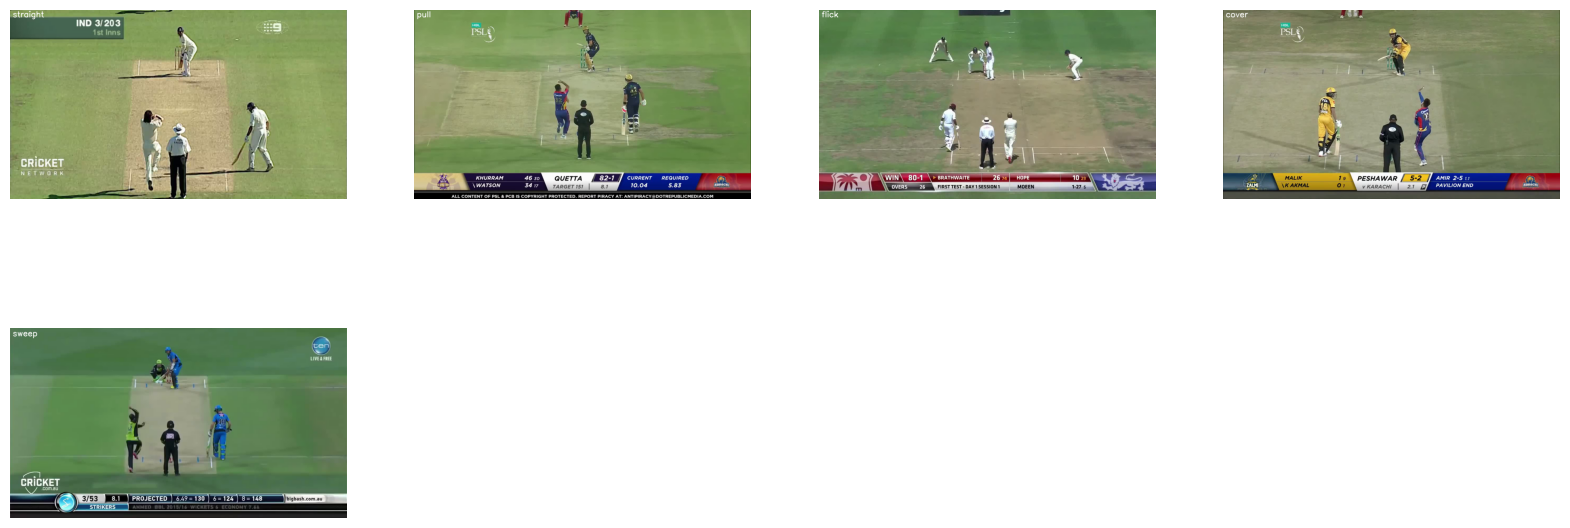

In [8]:
import os
import cv2
import random
import matplotlib.pyplot as plt

def display_random_video_frames(dataset_path, num_frames=20):
    """
    Display random frames from random videos in the specified dataset directory.

    Args:
    - dataset_path (str): Path to the dataset directory.
    - num_frames (int): Number of frames to display. Default is 20.
    """
    # Create a Matplotlib figure and specify the size of the figure.
    plt.figure(figsize=(20, 20))

    # Get the names of all classes/categories in the dataset.
    all_classes_names = os.listdir(dataset_path)

    # Generate a list of random class indices.
    random_indices = random.sample(range(len(all_classes_names)), min(num_frames, len(all_classes_names)))

    # Iterate through the randomly selected class indices.
    for counter, random_index in enumerate(random_indices, 1):
        # Retrieve the class name using the random index.
        selected_class_name = all_classes_names[random_index]

        # Retrieve the list of all video files present in the selected class directory.
        video_files_names_list = os.listdir(os.path.join(dataset_path, selected_class_name))

        # Randomly select a video file from the list retrieved from the selected class directory.
        selected_video_file_name = random.choice(video_files_names_list)

        # Initialize a VideoCapture object to read from the video file.
        video_reader = cv2.VideoCapture(os.path.join(dataset_path, selected_class_name, selected_video_file_name))

        # Read the first frame of the video file.
        _, bgr_frame = video_reader.read()

        # Release the VideoCapture object.
        video_reader.release()

        # Convert the frame from BGR into RGB format.
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Write the class name on the video frame.
        cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Display the frame.
        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

    # Show the Matplotlib figure with the randomly selected frames.
    plt.show()

# Example usage:
dataset_path = "C:/Data/Academics/VIT/Fall 2024/D - Digital Image Processing/DA Implementation/Dataset2"
display_random_video_frames(dataset_path)


## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [9]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 25



# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "C:/Data/Academics/VIT/Fall 2024/D - Digital Image Processing/DA Implementation/Dataset2"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["flick", "pull", "cover", "straight", "sweep"]

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        # Crop the frame to the specified region
        cropped_frame = frame[120:600, 360:920]

        # Resize the cropped frame to the desired dimensions
        resized_frame = cv2.resize(cropped_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Apply Bilateral Filter to reduce noise
        filtered_frame = cv2.bilateralFilter(resized_frame, 9, 75, 75)

        # Normalize the resized frame by dividing it by 255 so that each pixel value lies between 0 and 1
        normalized_frame = filtered_frame / 255

        # Append the normalized frame to the frames list
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list


### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [11]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [12]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: flick
Extracting Data of Class: pull
Extracting Data of Class: cover
Extracting Data of Class: straight
Extracting Data of Class: sweep


Now, we will perform data shuffling by shuffling the features and labels for improving the learning process of the model

In [13]:
import tensorflow as tf

# Convert features and labels to TensorFlow tensors
features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)


In [14]:
import tensorflow as tf
import numpy as np

# Combine features and labels tensors into a single dataset
dataset = tf.data.Dataset.from_tensor_slices((features_tensor, labels_tensor))

# Shuffle the dataset
buffer_size = len(features_tensor)  # Use the size of features tensor as buffer size
dataset_shuffled = dataset.shuffle(buffer_size)

# Define batch size and number of epochs
batch_size = 32
num_epochs = 10

# Batch and repeat the shuffled dataset
dataset_batched = dataset_shuffled.batch(batch_size).repeat(num_epochs)

# Convert the shuffled dataset back to NumPy arrays
shuffled_features = []
shuffled_labels = []
for batch in dataset_batched:
    features_batch, labels_batch = batch
    shuffled_features.append(features_batch.numpy())
    shuffled_labels.append(labels_batch.numpy())

# Concatenate the lists of batches into NumPy arrays
shuffled_features_array = np.concatenate(shuffled_features, axis=0)
shuffled_labels_array = np.concatenate(shuffled_labels, axis=0)


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [15]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(shuffled_labels_array)

In [16]:
print(one_hot_encoded_labels)

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [17]:
# Split the Data into Train ( 80% ) and Test Set ( 20% ).
features_train, features_test, labels_train, labels_test = train_test_split(shuffled_features_array, one_hot_encoded_labels,
                                                                            test_size = 0.2, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the proposed Approach</font>**

The architecture defines a neural network with both LSTM and convolutional layers, designed for action recognition using time-distributed images as input:

1. **Input Shape**: The input shape is defined as `(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)`, where `SEQUENCE_LENGTH` represents the number of frames in a sequence, `IMAGE_HEIGHT` and `IMAGE_WIDTH` are the dimensions of each image frame, and `3` refers to the RGB color channels.

2. **Convolutional Layers**: The model begins with TimeDistributed convolutional layers, consisting of Conv2D layers with ReLU activation, batch normalization, and MaxPooling2D layers. These layers extract spatial features from each frame of the input sequence and reduce the spatial dimensions.

3. **Dropout**: Dropout layers are added after each convolutional layer to prevent overfitting and improve the model's generalization.

4. **Flatten and LSTM Layer**: After processing the input through convolutional layers, the frames are flattened, and the model proceeds to an LSTM layer with 32 units. This recurrent layer captures temporal patterns across the sequence of frames.

5. **Dense Output Layer**: Finally, a dense output layer with softmax activation is added for classification. It maps the LSTM output to the number of classes in the dataset, providing a probability distribution across the classes.

6. **Regularization**: L2 regularization with a specified strength (`l2_reg_strength`) is applied to both the convolutional and LSTM layers to prevent overfitting by penalizing large weight values.

7. **Model Summary**: The model summary displays architecture details, including the number of parameters and the output shapes of each layer.

This architecture is designed to process sequences of images and classify them into different action classes using a combination of LSTM and convolutional neural network layers.


### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**



In [18]:
SEQUENCE_LENGTH = 25
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
CLASSES_LIST = ["flick", "pull", "cover", "straight", "sweep"]

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, LSTM, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

def create_LRCN_model():
    l2_reg_strength = 0.001
    model = Sequential()
    
    # TimeDistributed layers with convolutional and pooling layers
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg_strength)),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(BatchNormalization()))  # Add batch normalization
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.4)))  # Increased dropout rate
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg_strength))))
    model.add(TimeDistributed(BatchNormalization()))  # Add batch normalization
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.4)))  # Increased dropout rate
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg_strength))))
    model.add(TimeDistributed(BatchNormalization()))  # Add batch normalization
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))  # Increased dropout rate
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(l2_reg_strength))))
    model.add(TimeDistributed(BatchNormalization()))  # Add batch normalization
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.4)))  # Increased dropout rate
    
    # Flatten layer and LSTM layer
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32, kernel_regularizer=l2(l2_reg_strength)))
    
    # Output layer
    model.add(Dense(len(CLASSES_LIST), activation='softmax', kernel_regularizer=l2(l2_reg_strength)))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Display model summary
    model.summary()
    
    return model


Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [20]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")


C:\Users\Lionel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 25, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 25, 64, 64, 16) │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 25, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 25, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 25, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 25, 16, 16, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 25, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 25, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 25, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 25, 4, 4, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 25, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 25, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 25, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 25, 2, 2, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 25, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 25, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 25, 64)         │             

 Total params: 73,797 (288.27 KB)

 Trainable params: 73,445 (286.89 KB)

 Non-trainable params: 352 (1.38 KB)

Model Created Successfully!


### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [21]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks=early_stopping_callback)

Epoch 1/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 105s 200ms/step - accuracy: 0.2727 - loss: 1.7786 - val_accuracy: 0.2662 - val_loss: 2.0552
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 84s 195ms/step - accuracy: 0.4238 - loss: 1.5842 - val_accuracy: 0.4421 - val_loss: 1.7298
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 84s 193ms/step - accuracy: 0.5067 - loss: 1.3893 - val_accuracy: 0.5741 - val_loss: 1.3633
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 86s 199ms/step - accuracy: 0.6128 - loss: 1.2224 - val_accuracy: 0.4838 - val_loss: 1.7601
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 84s 195ms/step - accuracy: 0.6399 - loss: 1.1345 - val_accuracy: 0.5856 - val_loss: 1.3388
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 84s 194ms/step - accuracy: 0.6832 - loss: 1.0725 - val_accuracy: 0.6736 - val_loss: 1.2147
Epoch 7/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 85s 197ms/step - accuracy: 0.7056 - loss: 1.0045 - val_accuracy: 0.7037 - val_loss: 1.1804
Epoch 8/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 86s 200ms/step - accuracy: 0.7553 - loss: 

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

we will evaluate the model on the test set.

In [22]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8763 - loss: 0.7194


#### **<font style="color:rgb(134,19,348)">Plotting the trained Model</font>**

Now, we will plot the model and analyse the graph

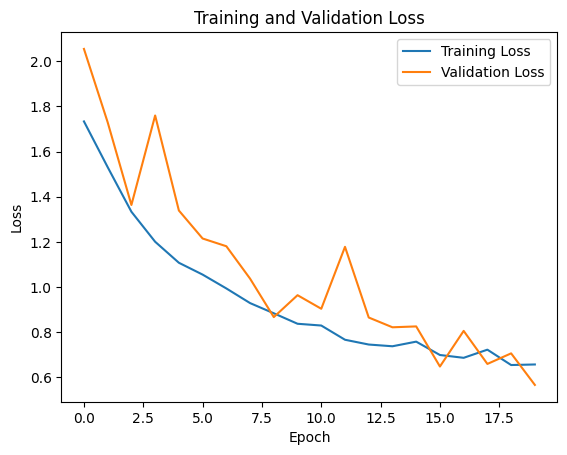

In [23]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure()
plt.plot(LRCN_model_training_history.history['loss'], label='Training Loss')
plt.plot(LRCN_model_training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

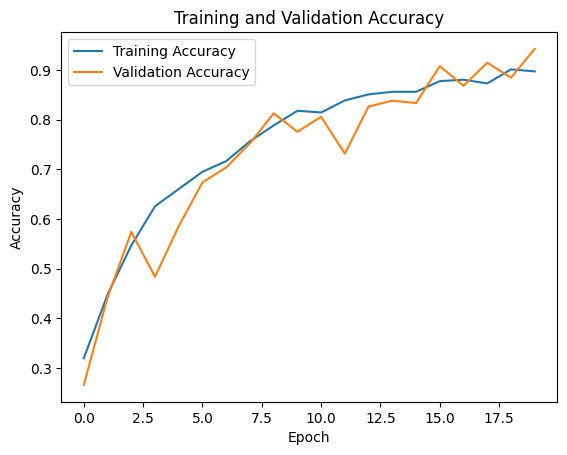

In [24]:
# Plot training and validation accuracy
plt.figure()
plt.plot(LRCN_model_training_history.history['accuracy'], label='Training Accuracy')
plt.plot(LRCN_model_training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## **<font style="color:rgb(134,19,348)">Step 5: Testing</font>**


### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**

Now let's create a function that will perform a single prediction for the complete videos. Next we will utilize the function **`predict_video_class()`** created above to perform a single prediction on test video.

In [25]:
import numpy as np
from tensorflow.keras.models import load_model

CLASSES_LIST = ["flick", "pull", "cover", "straight", "sweep"]
def predict_video_class(video_path, model):


    # Extract frames from the video
    frames = frames_extraction(video_path)
    
    # Convert frames list to numpy array and add a batch dimension
    frames = np.expand_dims(np.array(frames), axis=0)
    
    # Perform prediction
    predicted_probabilities = model.predict(frames)
    
    # Get the index of the class with the highest probability
    predicted_index = np.argmax(predicted_probabilities)
    
    # Map the index to the class label
    predicted_class = CLASSES_LIST[predicted_index]
    
    return predicted_class

Loading unseen videos and predicting the video class 

In [26]:
predicted_class = predict_video_class("C:/Data/Academics/VIT/Fall 2024/D - Digital Image Processing/DA Implementation/cover_0151.avi", LRCN_model)
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'cover'

In [27]:
predicted_class = predict_video_class("C:/Data/Academics/VIT/Fall 2024/D - Digital Image Processing/DA Implementation/flick_0097.avi", LRCN_model)
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


'flick'

In [28]:
predicted_class = predict_video_class("C:/Data/Academics/VIT/Fall 2024/D - Digital Image Processing/DA Implementation/straight_0078.avi", LRCN_model)
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


'straight'

In [29]:
predicted_class = predict_video_class("C:/Data/Academics/VIT/Fall 2024/D - Digital Image Processing/DA Implementation/sweep_0069.avi", LRCN_model)
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


'sweep'